## Set Environment and load data

In [1]:
import os
import sys
import pandas as pd
import codecs
import re
import unicodedata

from pyspark.sql import SparkSession
import pyspark.sql.functions as f

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# setup env inside docker

# add path with python packages installed outside of the docker
sys.path.append('/home/jovyan/work/98_sys_files/site-packages')
#!pip install pyallegro -t /home/jovyan/work/98_sys_files/site-packages 

# add jar driver to connect to sqlite
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /home/jovyan/work/98_sys_files/jar/sqlite-jdbc-3.28.0.jar pyspark-shell'

In [3]:
#run spark sesion 
spark = SparkSession.builder \
    .appName('lending-club-loan DataFrame') \
    .master('local[*]') \
    .getOrCreate()

# load schema
with codecs.open("/home/jovyan/work/01_data/jdbc_schema","r") as f:
    ncschema = f.read()

# load data from sqlite
driver = "org.sqlite.JDBC"
path = '/home/jovyan/work/01_data/db/database.sqlite'
url = "jdbc:sqlite:" + path
tablename = "loan"

DF = spark.read \
.option("driver", driver) \
.option("customSchema", ncschema) \
.jdbc(url, tablename)

# register sql table
DF.createOrReplaceTempView("loan")

https://www.kaggle.com/wendykan/lending-club-loan-data

## A glance at single record

In [4]:
DF.limit(1).show(vertical=True)

-RECORD 0--------------------------------------------------------
 id                                         |                    
 member_id                                  |                    
 loan_amnt                                  | 2500               
 funded_amnt                                | 2500               
 funded_amnt_inv                            | 2500               
 term                                       |  36 months         
 int_rate                                   | 13.56              
 installment                                | 84.92              
 grade                                      | C                  
 sub_grade                                  | C1                 
 emp_title                                  | Chef               
 emp_length                                 | 10+ years          
 home_ownership                             | RENT               
 annual_inc                                 | 55000              
 verificat

## Target

In this task target is a DEFAULT event defined as a `loan_status` which is taking on the following levels:   
* Charged off
* Default
* Does not meet the credit policy. Status: Charged Off
* Late (31-120 days)

[statuses meaning](https://help.lendingclub.com/hc/en-us/articles/216109367-What-do-the-different-Note-statuses-mean-) 

Few words about DEFAULT theory:
* DEFAULT is a set of events/status that bank classify as an incapability to pay back a loan.   
* To predict beforehand if client is at risk of default, bank use different tools that assess this probability.   
* **Reactive/ application scoring**   - the main aim of reactive scoring is to forecast the credit quality of loan applications submitted by customers. It attempts to predict the applicant’s probability of default if the application were accepted.   
* **Behavioral scoring** is used to review contracts that have already been formalized by incorporating information on customer behavior and on the contract itself. Unlike reactive scoring, it is an analysis, i.e. once the contract has been granted. 
* **Proactive scoring** tools take into account the same variables as behavioral scorings, but they have a different purpose, as they provide an overall ranking of the customer, rather than of a specific transaction. This customer perspective is supplemented by adjustments that depend on the type of product. 



<img src="https://i.imgur.com/D1Aszpq.jpg" width="700" >

Source: https://shareholdersandinvestors.bbva.com/microsites/bbva2012/en/Riskmanagement/ProbabilityofdefaultPD.html    


In [5]:
default_map = {
    'Fully Paid': '0',
    'Default' : '1',
    'In Grace Period': '0',
    'Does not meet the credit policy. Status:Fully Paid' : '0',
    'Charged Off': '1',
    'Late (31-120 days)' : '1',
    'Current' : '0',
    'Does not meet the credit policy. Status:Charged Off' : '1',
    'Late (16-30 days)' : '0'
}

In [6]:
print("Loan statuses distribution")
spark.sql(
    "SELECT loan_status,loan_status as default, count(*) as cnt from loan group by loan_status order by cnt desc") \
    .replace(default_map, subset="default").show(truncate=False)


+---------------------------------------------------+-------+-------+
|loan_status                                        |default|cnt    |
+---------------------------------------------------+-------+-------+
|Fully Paid                                         |0      |1041952|
|Current                                            |0      |919695 |
|Charged Off                                        |1      |261655 |
|Late (31-120 days)                                 |1      |21897  |
|In Grace Period                                    |0      |8952   |
|Late (16-30 days)                                  |0      |3737   |
|Does not meet the credit policy. Status:Fully Paid |0      |1988   |
|Does not meet the credit policy. Status:Charged Off|1      |761    |
|Default                                            |1      |31     |
+---------------------------------------------------+-------+-------+



In [7]:
import pyspark.sql.functions as f

default_in_time = DF.withColumn('default', f.col('loan_status')) \
    .replace(default_map, subset="default") \
    .select(f.col('default'), f.to_date("issue_d",'MMM-yyyy').alias("issue_d")) \
    .groupBy(['issue_d']) \
    .agg(f.sum('default').alias('default_cnt'), (f.sum('default')/f.count('default')).alias('default_rate')
        ,f.count('default').alias("cnt")).orderBy('issue_d').toPandas()

In [8]:
current_in_time = spark.sql("select distinct issue_d, count(*) as cnt from loan where loan_status = 'Current' group by issue_d order by issue_d") \
    .withColumn("issue_d",f.to_date("issue_d",'MMM-yyyy')).toPandas()


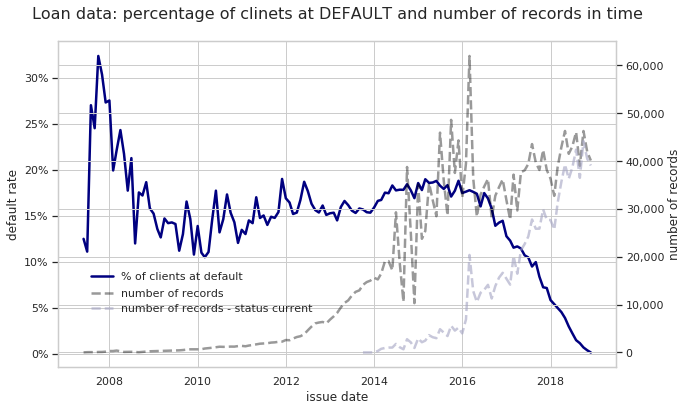

In [13]:
from matplotlib.ticker import FuncFormatter
import pyspark.sql.functions as f

sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

sns.lineplot(data=default_in_time, x='issue_d', y='default_rate', color='navy', alpha=1, linewidth=2.5, ax=ax1, label='% of clients at default')
sns.lineplot(data=default_in_time, x='issue_d', y='cnt', color='black',alpha=0.4, dashes=True, linewidth=2.5, ax=ax2, label='number of records')
sns.lineplot(data=current_in_time, x='issue_d', y='cnt', color='#a3a3c2',alpha=0.6, dashes=True, linewidth=2.5, ax=ax2, label='number of records - status current')

ax2.lines[0].set_linestyle("--")
ax2.lines[1].set_linestyle("--")

ax1.legend(loc = (.05,.25), frameon = False)
ax2.legend(loc = (.05, .15), frameon = False)

ax1.set(xlabel='issue date', ylabel='default rate')
ax2.set(ylabel='number of records')

plt.title('Loan data: percentage of clinets at DEFAULT and number of records in time', y=1.05, fontsize = 16)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y))) 


After 2016 default ratio is sharply decreasing contrariwise to the number of loans in status `current`.    
The younger the loan the lower risk of default. 

In [18]:
_tmp = spark.sql('select term, count(*) as cnt from loan group by term').toPandas()

In [20]:
_tmp.assign(prc = lambda x:x['cnt']/(1609754+650914))

,term,cnt,prc
0,36 months,1609754,0.71207
1,60 months,650914,0.28793


Acording to the website [www.lendingclub.com](https://www.lendingclub.com/info/download-data.action) this dataset contains mix of current and past loans:
>... files contain complete loan data for all loans issued through the time period stated, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter.


I will build predictive model of default according to **Reactive scoring** definition:
>Reactive scoring - the main aim of reactive scoring is to forecast the credit quality of loan applications submitted by customers. It attempts to predict the applicant’s probability of default if the application were accepted.

The default rate accounts for actually realized defaults over a given period, while PD is the predicted probability that a pool of obligors will default over the predefined future time horizon. This time horizon is– typically 12 months.

In this task target is a DEFAULT event defined as a `loan_status` which is taking on the following levels:   
* Charged off
* Default
* Does not meet the credit policy. Status: Charged Off
* Late (31-120 days)

The time horizon is not defined in task. 

Since the dataset is a mix of past and present loans I've decided to take a horizon of 36 months - it's the prevailing loan length time. 

### select  population for modeling


I choose only records with issue date less or equal to 2016-03:
* I estimate the "present date" on March/April of 2019 (its the max value of field `next_pymnt_d`), 
* in description is `The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter`
* most of loans (70%) has term is issued for 36 months,
* 2019.03 minus 36 months is 2016.03

In result 1 021 327 loans will be included (45% of whole dataset).

In [12]:
print("Distribution of 'next_pymnt_d': (since 2018-08) \n")

DF.select(f.to_date("next_pymnt_d",'MMM-yyyy').alias('next_pymnt_d')) \
          .filter(f.col("next_pymnt_d") > f.to_date(f.lit('2018-06-01'))) \
          .groupBy("next_pymnt_d").count().orderBy('next_pymnt_d') \
          .show(200, False)


Distribution of 'next_pymnt_d': (since 2018-08) 

+------------+------+
|next_pymnt_d|count |
+------------+------+
|2018-08-01  |1     |
|2018-09-01  |2     |
|2018-12-01  |3     |
|2019-02-01  |406   |
|2019-03-01  |953821|
|2019-04-01  |78    |
+------------+------+



In [52]:
_tmp = DF.select(f.to_date("issue_d",'MMM-yyyy').alias('issue_d')) \
          .select(f.when(f.col("issue_d") > f.to_date(f.lit('2016-03-01')),"N").otherwise("Y").alias("Include")) \
          .groupBy("Include").count().toPandas()
_tmp.assign(prc = lambda x:x['count']/(sum(_tmp['count'].values))) 

,Include,count,prc
0,Y,1021327,0.451781
1,N,1239341,0.548219


In [10]:
import datetime
default_in_time_in =default_in_time[(default_in_time['issue_d']<=datetime.datetime.strptime('2016-03', '%Y-%m').date())]
default_in_time_out =default_in_time[(default_in_time['issue_d']>datetime.datetime.strptime('2016-03', '%Y-%m').date())]


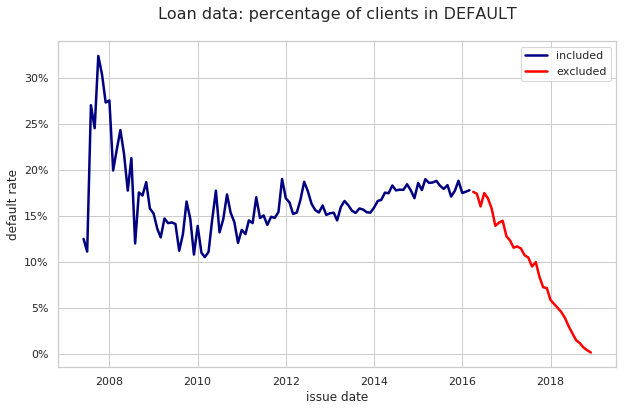

In [53]:
from matplotlib.ticker import FuncFormatter

sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(10,6))

sns.lineplot(data=default_in_time_in, x='issue_d', y='default_rate', color='navy', alpha=1, 
             linewidth=2.5, ax=ax1, label='included')
sns.lineplot(data=default_in_time_out, x='issue_d', y='default_rate', color='red', alpha=1, 
             linewidth=2.5, ax=ax1, label='excluded')
ax1.set(xlabel='issue date', ylabel='default rate')
plt.title('Loan data: percentage of clients in DEFAULT', y=1.05, fontsize = 16)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 


## Variables

Since I've decided to build application scoring I choose only the variable that are avilible at the moment of credit application.    
They are listed in "browseNotes" tab of LCDataDictionary.xlsx

In [84]:
import re
import unicodedata
def unic(string): return unicodedata.normalize("NFKD", string)

In [85]:
LCDataDictionary = pd.read_excel('../01_data/LCDataDictionary.xlsx',
                             sheet_name='browseNotes')

In [86]:
bn_or=[unic(i) for i in LCDataDictionary.BrowseNotesFile.tolist()[:-2]]
bn_md=[re.sub("[_ ]","",unic(i).lower()) for i in LCDataDictionary.BrowseNotesFile.tolist()[:-2]]
ds=DF.columns

In [87]:
selected_variables = ['issue_d']+[i for i in ds if re.sub("[_ ]","",i).lower() in bn_md]+['mths_since_recent_inq','last_credit_pull_d','verification_status_joint','mo_sin_old_il_acct','loan_status']


In [108]:
with codecs.open('../01_data/variables_browseNotes_select.txt','w') as f:
    for item in selected_variables:
        f.write("%s\n" % item)
    

manually maped 
```
creditPullD -> last_credit_pull_d
mthsSinceMostRecentInq -> mths_since_recent_inq
verified_status_joint -> verification_status_joint
mths_since_oldest_il_open -> mo_sin_old_il_acct
```

Not in dataset

```
acceptD
effective_int_rate
expD
ficoRangeHigh
ficoRangeLow
ils_exp_d
isIncV
listD
msa
mths_since_oldest_il_open
mthsSinceRecentLoanDelinq
reviewStatus
reviewStatusD
serviceFeeRate
sec_app_fico_range_low
sec_app_fico_range_high
```

In [109]:
with codecs.open('../01_data/variables_browseNotes_select.txt','r') as f:
    variables = [i[:-1] for i in f.readlines()]


In [107]:
DF.select(variables).limit(1).show(vertical=True)

-RECORD 0-------------------------------------------------
 issue_d                             | Dec-2018           
 id                                  |                    
 member_id                           |                    
 loan_amnt                           | 2500               
 funded_amnt                         | 2500               
 term                                |  36 months         
 int_rate                            | 13.56              
 installment                         | 84.92              
 grade                               | C                  
 sub_grade                           | C1                 
 emp_title                           | Chef               
 emp_length                          | 10+ years          
 home_ownership                      | RENT               
 annual_inc                          | 55000              
 url                                 |                    
 desc                                |                  